# Étude sur les facteurs qui déterminent la santé des enfants aux États-Unis

# Importation des libraries 

In [1]:
# -q : quiet --> réduction des messages
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import s3fs # pour récupérer les fichiers de l'espace de stockage S3
import pandas as pd # pour la gestion des dataframe
import geopandas as gpd # pour la gestion des données géographiques (fichiers .shp)
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
import os
import prince # pour l'analyse en Composantes Multiples
import seaborn as sns
from matplotlib.patches import Ellipse

import ipywidgets as widgets
from IPython.display import display

# Librairies propres pour faciliter la lecture du notebook

import script.clean_data as cd
import script.analyse_data as ad
import folium # création de cartes intéractives
from folium.features import Choropleth

## Récupération des bases de données

In [3]:
# Maximum 15 secondes

# (depuis le stockage S3 d'un membre du groupe via le dossier public diffusion)
# Stocker les fichiers dans un dossier data/nsch

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

chemin_lecture_nsch = "inacampan/diffusion/Determinants_of_children-s_health/NSCH/"
chemin_ecriture_nsch = "data/nsch/"

# Lecture des fichiers des bases de données
dfs = cd.lecture_fichier_sas(fs, chemin_lecture_nsch, chemin_ecriture_nsch)

# récuperér le guide technique du questionnaire
# ce fichier inclut le nom de la variable, la question qu'elle encode, l'année du questionnaire
# mais également des notes pour la compréhension de la base de données initiale

guide = cd.lecture_fichier_csv(fs, f"{chemin_lecture_nsch}NSCH_Dictionary.csv", f"{chemin_ecriture_nsch}NSCH_Dictionary.csv")

# Element de précaution : GUIDE contient plusieurs index de meme nom
# mais les caractéristiques ne sont pas identiques

In [4]:
# Maximum 2 secondes

# Récuperer les fichiers associés au shapefile - utiles pour les cartes (depuis le stockage S3 d'un membre du groupe)

chemin_lecture_map = "inacampan/diffusion/Determinants_of_children-s_health/Map/"
chemin_ecriture_map = "data/map/"

# lecture du fichier
gdf = cd.lecture_fichier_shapefile(fs, chemin_lecture_map, chemin_ecriture_map)

In [5]:
# Maximum 2 secondes
# Récuperer les données économiques - fichier csv
chemin_lecture_eco = "inacampan/diffusion/Determinants_of_children-s_health/Economic/"
chemin_ecriture_eco = "data/economic/"

# lecture du fichier
gdp = cd.lecture_fichier_csv(fs, 
                             f"{chemin_lecture_eco}SASUMMARY__ALL_AREAS_1998_2024.csv", 
                             f"{chemin_ecriture_eco}SASUMMARY__ALL_AREAS_1998_2024.csv")

## Description des données et statistiques descriptives

Conformément au site qui héberge les bases de données NSCH, le questionnaire de présélection (NSCH-S1) déterminait si l’adresse représentait une résidence occupée et s’il y avait des enfants admissibles âgés de 0 à 17 ans vivant à cette adresse échantillonnée.

Le questionnaire thématique ("topical") comprenait des questions détaillées portant sur un enfant sélectionné au hasard dans le ménage. Les ménages recevaient l’un des trois questionnaires thématiques spécifiques à l’âge, en fonction de l’âge de l’enfant échantillonné : 
* NSCH-T1 (ou T1) pour les enfants âgés de 0 à 5 ans,
* NSCH-T2 (ou T2) pour les enfants âgés de 6 à 11 ans, ou
* NSCH-T3 (ou T3) pour les enfants âgés de 12 à 17 ans.

Le type du questionnaire est codé dans la variable ```FORMTYPE```.
Dans notre projet nous regardons uniquement le questionnaire "topical". 

In [6]:
df = dfs["2023"] # regardons d'abord l'année 2023
df.describe()

,HEIGHT,TOTKIDS_R,TENURE,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,K2Q35A_1_YEARS,BIRTH_MO,BIRTH_YR,K6Q41R_STILL,...,HHCOUNT_IF,HIGRADE,HIGRADE_TVIS,FPL_I1,FPL_I2,FPL_I3,FPL_I4,FPL_I5,FPL_I6,FWC
count,32319.000000,55162.000000,55162.000000,54862.000000,55162.000000,55162.000000,1971.000000,54770.000000,54675.000000,18118.000000,...,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000
mean,151.687657,1.876690,1.455187,1.126135,8.339563,1.486422,4.868087,6.613255,2014.314092,1.884204,...,0.031761,2.829393,3.485606,287.280537,287.401998,287.531362,288.364091,287.652804,287.905080,1308.472653
std,20.522720,0.870582,0.787676,0.439835,5.303088,0.499820,3.478265,3.404391,5.324464,0.319990,...,0.175365,0.436074,0.799796,124.920459,124.878680,124.957976,124.475651,124.808909,124.524807,2334.642676
min,93.980000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2005.000000,1.000000,...,0.000000,1.000000,1.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,11.006690
25%,134.620000,1.000000,1.000000,1.000000,4.000000,1.000000,2.000000,4.000000,2009.000000,2.000000,...,0.000000,3.000000,3.000000,179.000000,179.000000,179.000000,182.000000,179.000000,181.000000,263.179394
50%,154.940000,2.000000,1.000000,1.000000,8.000000,1.000000,3.000000,7.000000,2015.000000,2.000000,...,0.000000,3.000000,4.000000,337.000000,337.000000,337.000000,337.500000,337.000000,337.000000,639.147322
75%,167.630000,2.000000,2.000000,1.000000,13.000000,2.000000,6.000000,10.000000,2019.000000,2.000000,...,0.000000,3.000000,4.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,1416.809570
max,211.050000,4.000000,4.000000,3.000000,17.000000,2.000000,15.000000,12.000000,2023.000000,2.000000,...,1.000000,3.000000,4.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,54078.402188


In [7]:
# La base de données de 2023 est dense, avec un total de 452 de variables sur 55162 individus (à travers les états-Unis).
# Sur l'ensemble des enfants dans l'échantillons : 
# (i) 21524 sont âgés de 0 à 5 ans,
# (ii) 18397 sont âgés de 6 à 11 ans et 
# (iii) 15241 sont âgés de 11 à 17 ans.

print(df["FORMTYPE"].value_counts())
print(df["FIPSST"].value_counts()[:5])

FORMTYPE
T1    21524
T3    18397
T2    15241
Name: count, dtype: int64
FIPSST
06    4696
20    2805
27    2400
22    2093
39    1735
Name: count, dtype: int64


On regarde le pourcentage de valeurs manquantes par colonne, par ordre décroissant.
On observe des taux de valeurs manquantes très élevés pour certaines questions qui ne sont posées que dans des cas très spécifiques et qui dépendent d’une réponse précédente. (Cela est rassurant.)

Par exemple, pour la variable ```CYSFIB_SCREEN``` (avec un taux de 99.94% de valeurs manquantes), celle-ci encode la question :

**Was this condition identified through a blood test done shortly after birth? … These tests are sometimes called newborn screening.** Cette question est ignorée si ```CYSTFIB = 2```. La variables ```CYSFIB``` a un taux très très faible (0.19%) de valeurs manquantes et parmi les valeurs prises, ```CYSFIB!=2``` dans seulement 30 questionnaires.

Pour les variables ```DIABETES_DESC``` et ```DIABETES_CURR```, les questions qu'elles encodent sont ignorées dès lorsque ```DIABETES = 2``` (ce qui regroupe seulement 40 questionnaires).

In [8]:
missing_values = df.isna().mean().sort_values(ascending=False) * 100

print("Valeurs manquantes en pourcentage par colonne\n",
    missing_values)
print("Nombre de colonnes avec au moins 50% de valeurs manquantes\n",(missing_values >= 50).sum())

# Illustration de l'exemple de CYSTFIB et DIABETES
print("---------------------------------")
print("Informations sur la variable CYSTFIB_SCREEN : ", guide[guide["Variable"] == "CYSTFIB_SCREEN"]["Universe"].iloc[0], "\n",
    guide[guide["Variable"] == "CYSTFIB"]["Question"].iloc[0])
print("Valeurs manquantes pour la variable CYSTFIB : \n",
    (df["CYSTFIB"].isna().mean() * 100).round(2), "%")
print(df["CYSTFIB"].value_counts())

print("---------------------------------")
print("Informations sur la variable DIABETES_CURR : ", guide[guide["Variable"] == "DIABETES_CURR"]["Universe"].iloc[0], "\n",
    guide[guide["Variable"] == "DIABETES"]["Question"].iloc[0])
print("Valeurs manquantes pour la variable DIABETES : \n",
    (df["DIABETES"].isna().mean() * 100).round(2), "%")
print(df["DIABETES"].value_counts())

Valeurs manquantes en pourcentage par colonne
 CYSTFIB_SCREEN    99.949240
DIABETES_DESC     99.945615
DIABETES_CURR     99.922048
K2Q38C            99.789710
LIVEUSA_MO        99.778833
                    ...    
FPL_I3             0.000000
FPL_I4             0.000000
FPL_I5             0.000000
FPL_I6             0.000000
FWC                0.000000
Length: 456, dtype: float64
Nombre de colonnes avec au moins 50% de valeurs manquantes
 180
---------------------------------
Informations sur la variable CYSTFIB_SCREEN :  Skip if CYSTFIB=2 
 Header: Has a doctor or other health care provider EVER told you that this child has......Cystic Fibrosis?
Valeurs manquantes pour la variable CYSTFIB : 
 0.19 %
CYSTFIB
2.0    55025
1.0       30
Name: count, dtype: int64
---------------------------------
Informations sur la variable DIABETES_CURR :  Skip if DIABETES=2 
 Header: Has a doctor or other health care provider EVER told you that this child has......Type 2 Diabetes?
Valeurs manquantes pou

### Choix des variables d'intérêt

Dans le guide, les variables sont classées dans plusieurs grandes catégories, en fonction de la question de recherche et également de la base de données associée. En vue de notre base de données, on peut garder uniquement les variables de type "Topical" et "Operational" (colonne "Source").

In [9]:
guide = guide[guide["Source"].isin({"Topical", "Operational"})]

years = {"2021", "2022", "2023", "2024"}

# On garde uniquement des variables qui sont communes aux quatre dataset NSCH
guide = guide[guide["Survey Years"].apply(
    lambda x: years <= set(y.strip() for y in str(x).split(","))
)]

# Cela réduit la base à 318 variables communes entre les databases
# Netoyer les dataframe NSCH avec cette contrainte, en rajoutant le code de l'état de résidance
# comme variable admissible, ainsi que la taille et le poids de l'enfant.

variables_com = set(guide["Variable"])
variables_com = variables_com | {"FIPSST", "WEIGHT", "HEIGHT"}

for year in ["2023", "2022", "2021", "2024"]:
    df = dfs[year]
    df = df.loc[:, df.columns.isin(variables_com)]
    dfs[year] = df

In [10]:
counts = guide.groupby(["Source", "Topic"])["Variable"].count().reset_index(name="count")
print("Nombre de variable par groupe de (Source, Topic)\n",counts.to_string())

Nombre de variable par groupe de (Source, Topic)
          Source                            Topic  count
0   Operational                Data Quality Flag      1
1   Operational                        Geography      4
2   Operational                  Imputation Flag     10
3   Operational                      Operational      3
4   Operational                           Weight      3
5       Topical           A. This Child's Health     83
6       Topical       B. This Child as an Infant     19
7       Topical          C. Health Care Services     61
8       Topical         D. Health Care Providers     25
9       Topical     E. Health Insurance Coverage     13
10      Topical         F. Providing Health Care      8
11      Topical       G. Learning and Activities     33
12      Topical      H. About You and This Child     19
13      Topical     I. Your Family and Household     36
14      Topical  J. About You/Child's Caregivers     18
15      Topical         K. Household Information     1

In [11]:
# Sélectionner des variables dans l'univers "All Children" => cad des questions posées à toutes les groupes d'age

filter_variables = {
    var for var in variables_com
    if guide[guide["Variable"] == var]["Universe"].item() == "All Children"
}

# Proposition : 
final_variables = {

    # topical variables
    "ACE1", "ACE10", "ACE11", "ARRANGEHC", "ATHOMEHC", "AVOIDCHG", "C4Q04", "CURRCOV",
    "BLINDNESS", "BLOOD", "BREATHING", "CAVITIES", "DOWNSYN", "FOODSIT", "HCABILITY", "HEART", "HOWMUCH",
    "K2Q30A", "K2Q31A", "K2Q60A", "K4Q23", "K8Q11", "K8Q34", "SCREENTIME", "VIDEOPHONE", "SWALLOWING",
    "OVERWEIGHT",
    
    # operational variables
    "BIRTH_YR_F", "FIPSST", "FORMTYPE",
    "METRO_YN", "MPC_YN",
    "FWC", # le poids de la réponse
    "YEAR", "HHID",

    # Uniquement pour les formulaires T2 et T3
    "WEIGHT", # le poids en KG de l'enfant
    "HEIGHT" # la taille en CM de l'enfant
}

topical_variables = {"ACE1", "ACE10", "ACE11", "ARRANGEHC", "ATHOMEHC", "AVOIDCHG", "C4Q04", "CURRCOV",
    "BLINDNESS", "BLOOD", "BREATHING", "CAVITIES", "DOWNSYN", "FOODSIT", "HCABILITY", "HEART", "HOWMUCH",
    "K2Q30A", "K2Q31A", "K2Q60A", "K4Q23", "K8Q11", "K8Q34", "SCREENTIME", "VIDEOPHONE", "SWALLOWING",
    "OVERWEIGHT"}
     
guide = guide[
    guide["Variable"].isin(final_variables) &  # garde seulement si la variable est dans variables_finales
    guide["Survey Years"].apply(lambda x: "2024" in x)  # garde seulement si '2024' est dans years
]

cd.write_questions(final_variables, guide)

In [12]:
for year in ["2024", "2023", "2022", "2021"]:
    df = dfs[year]
    df = df.loc[:, df.columns.isin(final_variables)]
    dfs[year] = df

In [13]:
df = dfs["2023"]
df.head()

,HEIGHT,FIPSST,FORMTYPE,BREATHING,SWALLOWING,CAVITIES,BLINDNESS,HEART,DOWNSYN,BLOOD,...,K8Q11,FOODSIT,HCABILITY,C4Q04,ACE1,METRO_YN,MPC_YN,BIRTH_YR_F,WEIGHT,FWC
0,NaN,06,T2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,NaN,1318.476839
1,149.86,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,54.43,978.499881
2,157.47,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,2.0,1.0,4.0,1.0,1.0,1.0,0.0,57.15,904.191765
3,157.47,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,58.97,1092.097256
4,149.86,06,T2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,3.0,1.0,2.0,1.0,1.0,1.0,0.0,42.18,586.387870


In [14]:
missing_values = df.isna().mean().sort_values(ascending=False) * 100
print(missing_values)

HEIGHT        41.410754
WEIGHT        40.357492
MPC_YN        13.871868
METRO_YN       9.767594
ACE10          4.006381
ACE11          3.790653
VIDEOPHONE     3.525978
FOODSIT        2.585113
K4Q23          2.224357
K8Q34          2.155469
K8Q11          1.881730
ACE1           1.859976
SCREENTIME     1.751206
HOWMUCH        1.252674
AVOIDCHG       1.209166
ARRANGEHC      1.089518
ATHOMEHC       1.084080
K2Q31A         0.748704
C4Q04          0.725137
CURRCOV        0.648997
OVERWEIGHT     0.638120
HCABILITY      0.616366
SWALLOWING     0.598238
K2Q60A         0.429644
K2Q30A         0.422392
BLINDNESS      0.395200
BLOOD          0.373445
CAVITIES       0.366194
BREATHING      0.348066
DOWNSYN        0.328124
HEART          0.201225
FORMTYPE       0.000000
FIPSST         0.000000
BIRTH_YR_F     0.000000
FWC            0.000000
dtype: float64


In [15]:
# Cas particulier de HEIGHT et WEIGHT
df_not_t1 = df[df['FORMTYPE'] != 'T1']

# Compter les NA dans la colonne 'height' et 'weight
nb_na_height = df_not_t1['HEIGHT'].isna().sum()
nb_na_weight = df_not_t1['WEIGHT'].isna().sum()

pct_na_height = (nb_na_height / len(df_not_t1)) * 100
pct_na_weight = (nb_na_weight / len(df_not_t1)) * 100

print(f"Pourcentage de HEIGHT manquants (pour la sous-population > 5 ans): {pct_na_height:.2f}%")
print(f"Pourcentage de WEIGHT manquants (pour la sous-population > 5 ans): {pct_na_weight:.2f}%")

Pourcentage de HEIGHT manquants (pour la sous-population > 5 ans): 3.92%
Pourcentage de WEIGHT manquants (pour la sous-population > 5 ans): 2.19%


In [16]:
for var in df.columns:
    print("Variable : " + var + " prend " + str(len(df[var].unique())) + " valeurs uniques")
    print(df[var].unique())

# On a une variable qui est à moitié catégorielles - le ID de l'état
# On a trois variables continue
#    - la pondération de la réponse (FWC) : 0 valeurs manquantes
#     - le poids de l'enfant (seulement pour > 5 ans)
#     - la taille de l'enfant (seulement pour > 5 ans)

Variable : HEIGHT prend 70 valeurs uniques
[   nan 149.86 157.47 165.1  167.63 154.94 175.26 139.7  124.46 177.8
 142.24 132.08 106.65 185.41 160.02 121.92 170.18 104.1  187.95 152.4
 137.16 180.31 172.72 109.21 134.62 162.56 127.   147.32 146.46 182.87
 190.5  119.32 195.58 129.54 111.76 144.78  93.98 101.49 112.46 148.36
 128.41 159.63 116.82 114.28 150.   130.   135.   140.   120.   122.67
 164.57 171.71 155.   133.69 174.83 145.   211.05 193.04 115.   136.95
  99.06 198.12 125.   138.34  96.52 161.99 110.   169.9  202.67 143.  ]
Variable : FIPSST prend 51 valeurs uniques
['06' '44' '20' '01' '17' '22' '08' '12' '13' '46' '38' '21' '26' '34'
 '27' '19' '18' '55' '05' '49' '16' '40' '31' '48' '02' '42' '30' '35'
 '39' '47' '51' '45' '56' '28' '29' '24' '23' '33' '25' '41' '50' '36'
 '54' '09' '15' '53' '32' '04' '37' '10' '11']
Variable : FORMTYPE prend 3 valeurs uniques
['T2' 'T3' 'T1']
Variable : BREATHING prend 3 valeurs uniques
[ 1.  2. nan]
Variable : SWALLOWING prend 3 valeurs 

### Imputation

Pour s'y prendre, on utilise la librairie scikit-learn et une imputation via la méthode des K plus proches voisins : [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html). Nous utilisons un nombre de voisins égal à 3 (au lieu du 5 par défaut), par soucis de simplicité. De plus, nos variables manquantes étant catégorielles, un choix trop élevé de voisins à considérer n'est pas justifiable. Pour ```HEIGHT``` et ```WEIGHT``` on effectue une imputation uniquement au niveau de la sous-population telle que ```"FORMTYPE"!='T1'```.

In [17]:
# Cette cellule prend environ 5 à 12 minutes pour s'executer
# On recommande d'executer directement la cellule suivante qui récupère ce résultat depuis le S3

"""
years = ["2024", "2023", "2022", "2021"]
dfs_final = cd.impute_values_over_dataset(years, dfs)
"""

'\nyears = ["2024", "2023", "2022", "2021"]\ndfs_final = cd.impute_values_over_dataset(years, dfs)\n'

In [18]:
# Sauvegarde initiale sous S3 - via le compte inacampan - executé une seule fois 

#cd.write_on_S3(fs, years, dfs_final)


In [19]:
dfs_final = cd.read_on_S3(fs, years)

In [20]:
cd.test_imputed(years, dfs_final)

---------------OK----------------------


In [21]:
# visualisation de bar plot pour chaque variable catégorielle, post imputation
# possibilité de sélectionner la variable et l'année suhaitée de la base de données

year_selector = widgets.Dropdown(
    options = ["2024", "2023", "2022", "2021"],
    description = 'Année',
    value = "2023"
)

var_selector = widgets.Dropdown(
    options=list(topical_variables),
    description='Variable:',
    value='BREATHING'
)

interactive_plot = widgets.interactive(
    ad.bar_plot,
    variable=var_selector,
    year=year_selector,
    dfs=widgets.fixed(dfs_final),
    guide=widgets.fixed(guide)
)

display(interactive_plot)

interactive(children=(Dropdown(description='Année', index=1, options=('2024', '2023', '2022', '2021'), value='…

### Réalisation d'une Analyse en Composantes Multiples

La MCA (Multiple Correspondence Analysis) est une technique d’analyse statistique qui permet de réduire la dimensionnalité de données catégorielles et de visualiser les relations entre variables et individus. La librairie [Prince](https://pypi.org/project/prince/) en Python facilite cette analyse et la visualisation des résultats.

In [22]:
df_mca, mca = ad.mca_analysis("2023", dfs_final, 
                              ["FWC", "FIPSST", "FORMTYPE", "HEIGHT", "WEIGHT", "BIRTH_YR_F"])

In [23]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.139,7.22%,7.22%
1,0.066,3.42%,10.65%


In [24]:
mca.row_coordinates(df_mca).head()

,0,1
0,0.051042,-0.111438
1,0.130667,-0.319691
2,0.194635,0.061374
3,-0.248484,0.097365
4,0.012555,-0.114818


In [25]:
mca.column_coordinates(df_mca).head()

,0,1
BREATHING__1,0.877232,-0.206921
BREATHING__2,-0.071440,0.016851
SWALLOWING__1,2.298608,2.015780
SWALLOWING__2,-0.038556,-0.033812
CAVITIES__1,0.529369,-0.285518


On voit beaucoup de points regroupés vers le coin gauche-bas. Cela signifie que la majorité des individus partagent des modalités similaires sur les variables catégorielles.

Les points plus éloignés sont des individus atypiques ou ayant des combinaisons rares de modalités.

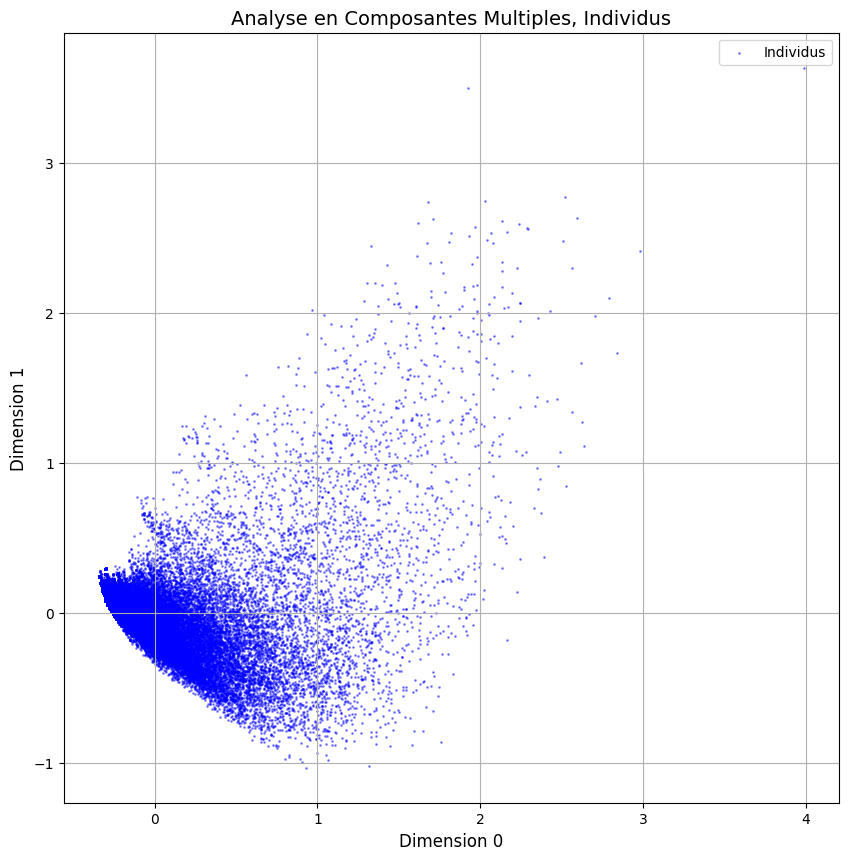

In [26]:
plot_individus = ad.mca_plot_individuals(df_mca, mca)

In [27]:
# Visualisation par groupes
# Le dataframe comporte beaucoup de colonnes => difficile de plotter un graphe à la fois

# Ajouter un coté interactif : l'utilisateur choisi la variable de regroupement qu'il souhaite

var_selector = widgets.Dropdown( # Dropdown : liste avec les options qui s'affiche en cliquant
    df_mca=widgets.fixed(df_mca),  # valeur fixée au préalable, l'utilisateur n'a pas de choix
    mca=widgets.fixed(mca), # valeur fixée au préalable, l'utilisateur n'a pas de choix
    guide = widgets.fixed(guide), # valeur fixée au préalable, l'utilisateur n'a pas de choix
    options=df_mca.columns, # Variable à choisir
    description='Variable:',
    value='BREATHING' # la valeur par défault
)

interactive_plot = widgets.interactive(ad.mca_plot_individuals_group, # la fonction prend 4 paramètres
                    variable=var_selector,
                    df_mca=widgets.fixed(df_mca),
                    mca=widgets.fixed(mca),
                    guide = widgets.fixed(guide))

display(interactive_plot)

interactive(children=(Dropdown(description='Variable:', options=('BREATHING', 'SWALLOWING', 'CAVITIES', 'BLIND…

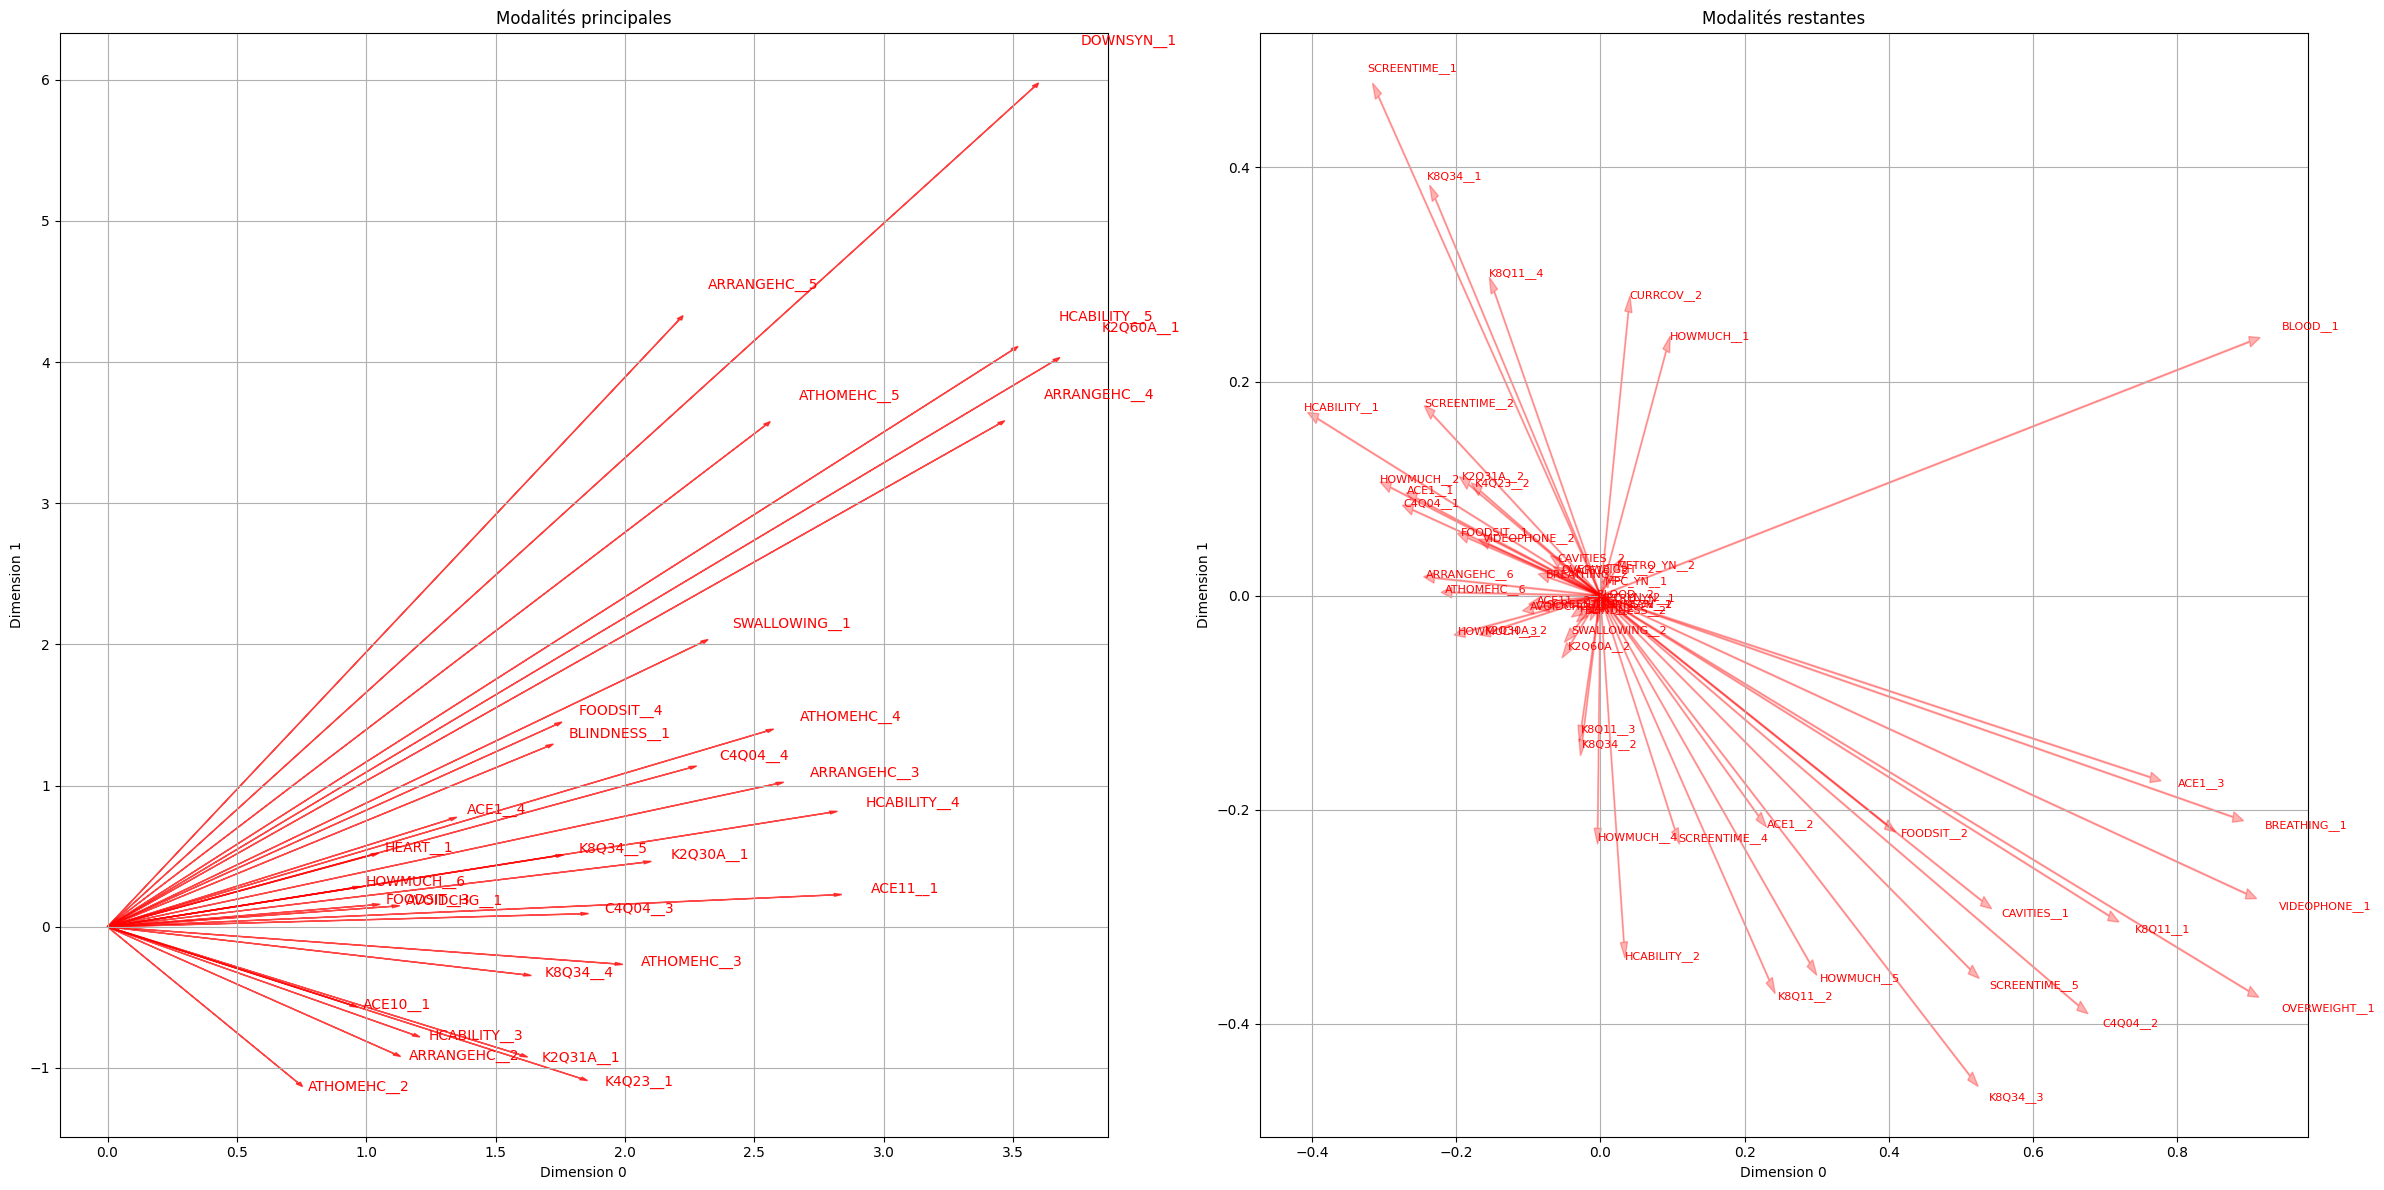

In [28]:
plot_modalites = ad.mca_plot_categories(df_mca, mca, 30)

Beaucoup de cases proche du bleu clair/bleu moyen illustrent des corrélations modestes à modérées, plutôt faibles globalement.
De petits îlots rouge‑orangés indiquent quelques paires assez corrélées positivement, par exemple autour de ```ACE11```(To the best of your knowledge, has this child EVER experienced any of the following? Treated or judged unfairly because of a health condition or disability) et ```K2Q60A```(Has a doctor, other health care provider, or educator EVER told you that this child has......Intellectual Disability (formerly known as Mental Retardation?), et plus bas autour de ```FOODSIT```(Which of these statements best describes your household's ability to afford the food you need DURING THE PAST 12 MONTHS?), ```ACE1```(SINCE THIS CHILD WAS BORN, how often has it been very hard to cover the basics, like food or housing, on your family's income?) et ```K8Q34```(DURING THE PAST MONTH, how often have you felt:...Angry with this child?).

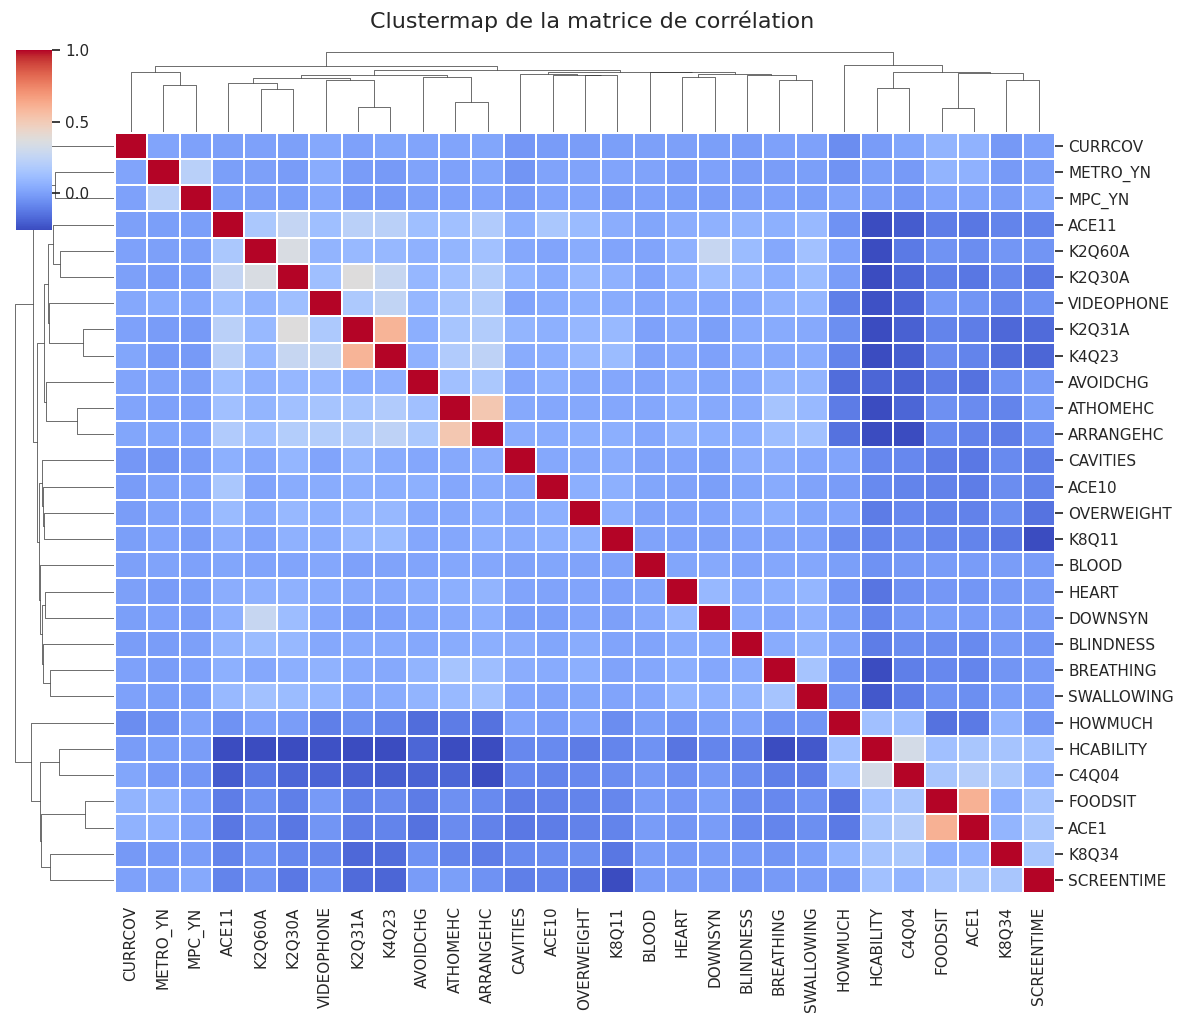

In [29]:
ad.heatmap_generator(df_mca)

## Enrichissement de la base de données

In [30]:
# Enrichissement avec la jointure entre la base économique et la base géographique

df_eco_geo = cd.clean_enrichment_datasets(gdp, gdf)

Dans cette nouvelle base de données économiques, nous remarquons six colonnes vides pour les données de 2024. Le reste de la base ne présente aucune valeur manquante.

### Colonnes manquantes pour 2024
1. `Implicit regional price deflator`
2. `Real PCE (millions of constant (2017) dollars)`
3. `Regional price parities (RPPs)`
4. `Real per capita personal income`
5. `Real personal income (millions of constant (2017) dollars)`
6. `Real per capita PCE`

Suite à l'absence du déflateur des prix au niveau des états, certaines variables ne sont juste pas calculables. Cela arrive surtout dans les bases de données locales ou régionales, où certains indicateurs ne sont pas systématiquement rapportés.

### Colonnes présentes pour 2024
1. Disposable personal income
2. Personal consumption expenditures
3. Per capita personal income
4. Per capita personal consumption expenditures (PCE)
5. Per capita disposable personal income
6. Gross domestic product (GDP)
7. Real GDP (millions of chained 2017 dollars)
8. Personal income
9. Total employment (number of jobs)


In [31]:
missing_values = df_eco_geo.isna().mean().sort_values(ascending=False) * 100
print(missing_values[:10])

2024_Real per capita personal income 4/                               100.0
2024_Real personal income (millions of constant (2017) dollars) 2/    100.0
2024_Real PCE (millions of constant (2017) dollars) 3/                100.0
2024_Real per capita PCE 5/                                           100.0
2024_Regional price parities (RPPs) 9/                                100.0
2024_Implicit regional price deflator 10/                             100.0
2018_Per capita personal consumption expenditures (PCE) 8/              0.0
2018_Per capita disposable personal income 7/                           0.0
2018_Personal consumption expenditures                                  0.0
2018_Personal income                                                    0.0
dtype: float64


In [ ]:
# brouillon affichage de PIB par état
# idée : utiliser ce code pour la carte finale, quand on aura calculé les indices de santé par état
year = 2024
column  =f"{year}_Real GDP (millions of chained 2017 dollars) 1/"

# convertion du type de la base de données

gdf = gpd.GeoDataFrame(df_eco_geo, geometry='geometry')

# Centrer la carte sur les USA
m = folium.Map([43, -100], zoom_start=4)

# Ajouter une carte choroplèthe
folium.Choropleth(
    geo_data=gdf,
    data=df_eco_geo,
    columns = ["GeoName",column],
    key_on="feature.properties.GeoName",
    fill_opacity=0.3,
    line_weight=2,
    highlight=True,
    fill_color = "viridis"
).add_to(m)

m